# LeNet-5 from scratch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchvision import datasets, transforms 

from modules.activation import SquashedTanh
from modules.criterion import MSE
from modules.init import LeCun
from modules.layer import Linear, Conv, Flatten, RBF
from modules.loader import DatasetLoader
from modules.model import RBF_Sequential
from modules.optimizer import Adam
from modules.pooling import AvgPool
from modules.constant import ASCII_BITMAP, C3_MAPPING

Create a composed transform to transform the data into images in the dimension of (32, 32) and normalized the pixel values to accelerate learning 

In [2]:
composed_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

Split the dataset into training and testing data and labels

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=composed_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=composed_transform)

X_train = np.array([data[0].numpy() for data in train_dataset])
y_train = np.array([data[1] for data in train_dataset])
X_test = np.array([data[0].numpy() for data in test_dataset])
y_test = np.array([data[1] for data in test_dataset])

LeNet-5 Architecture

<img src='./img/architecture.png' width=100%>

The activation function of the LeNet model <code>SquashedTanh</code> is a modification of the Tanh function with $S=\frac{2}{3}$ and $A=1.7159$

<img src='img/activation.png' width=50%>

The feature maps in layer C3 (<code>C3_MAPPING</code>) takes specific output channels from S2 according to the following table

<img src='img/mappings.png' width=50%>

The final RBF output layer which takes in <code>ASCII_BITMAP</code> as parameter is composed of feature maps of digit 0-9. During training phrase, the output of the model will be compared against the feature map of the ground truth and evaluate the loss for the sample using the <code>MSE</code> loss function, then the model parameters will be updated in backpropagation.

<img src='img/ascii_mapping.png' width=50%>

In [4]:
init_method = LeCun()

model = RBF_Sequential([
    # Conv Layers
    Conv((32, 32), 256, 1, 6, 5), #c1
    AvgPool(2), #s2
    SquashedTanh(),
    Conv((14, 14), 256, 6, 16, 5, mapping=C3_MAPPING), #c3
    AvgPool(2), #s4
    SquashedTanh(), 
    Conv((5, 5), 256, 16, 120, 5), #c5
    SquashedTanh(),
    
    # FC Layers
    Flatten(),
    Linear(120, 84, init_method), #f6
    SquashedTanh(),
    RBF(ASCII_BITMAP) #output
])

In [6]:
criterion = MSE()
optimizer = Adam(model, lr=0.001)

Train the model with hyperparameters <code>epochs</code>=10 and <code>batch_size</code>=128

In [ ]:
batch_size = 128
epochs = 10


Epoch 1


Testing: 100%|██████████| 78/78 [01:54<00:00,  1.46s/it]


Accuracy: 0.7923 | Loss: 624681.314274366

Epoch 2


Testing: 100%|██████████| 78/78 [01:50<00:00,  1.41s/it]


Accuracy: 0.8171 | Loss: 348798.5189457388

Epoch 3


Testing: 100%|██████████| 78/78 [02:16<00:00,  1.75s/it]

Accuracy: 0.8253 | Loss: 325782.25787257234


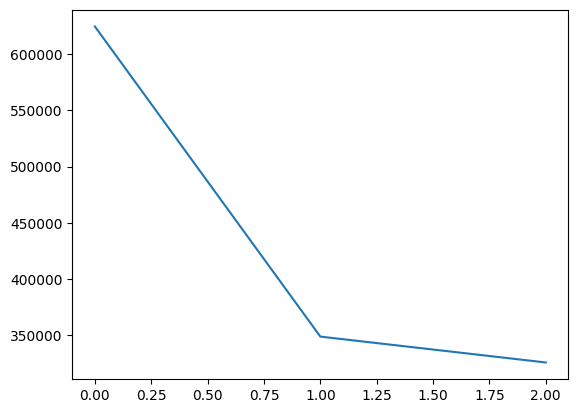

In [7]:
loss_list = []
acc_list = []
train_loader = DatasetLoader(X_train, y_train, batch_size=batch_size)
test_loader = DatasetLoader(X_test, y_test, batch_size=batch_size)

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}')
    loss = 0
    model.train()

    for X, y in tqdm(train_loader, desc='Training'):
        y_pred = model(X, y=y)
        loss += criterion(y, y_pred)
        grad = criterion.backward()
        model.backward(grad)
        optimizer.step()

    correct = 0
    model.eval()

    for X, y in tqdm(test_loader, desc='Testing'):
        y_pred = model(X)
        correct += np.sum(y_pred == y)

    acc = correct / len(y_test)
    acc_list.append(acc)
    loss_list.append(loss)
    print(f'Accuracy: {acc} | Loss: {loss}')

plt.plot(loss_list)
plt.show()

Save the model using Pickle for future inference

In [ ]:
save_model(model, 'models/model_10ep.pkl')

True

Validate the model accuracy for the testing dataset

In [ ]:
test_acc = test(
    model, X_test, y_test, 128
)

Testing: 100%|██████████| 78/78 [01:53<00:00,  1.46s/it]


In [ ]:
print(f'Test Accuracy: {test_acc * 100}%')

Test Accuracy: 93.34%


The model shows a reasonably high accuracy for the digit prediction. To further enhance the accuracy, load the saved model using the <code>load_model</code> function from modules.utils and continue training.